In [48]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import scipy.signal as sps
import heartpy as hp

import warnings
warnings.filterwarnings("ignore")

In [2]:
x = np.arange(0, 5, step=0.01)
y1 = x**2
freq = 5/(2*np.pi)
print(freq)
y_sin = np.sin(x*2*np.pi*freq)
y2 = y_sin + y1

0.7957747154594768


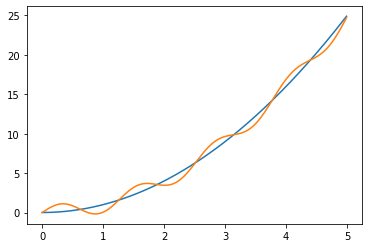

In [3]:
plt.plot(x, y1)
plt.plot(x, y2)

Strongest frequency: 200.78


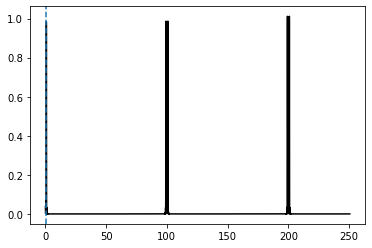

In [4]:
ls_sin = LombScargle(x, y_sin)
freq_sin, power_sin = ls_sin.autopower()
plt.plot(freq_sin, power_sin, '-k', rasterized=True)
plt.axvline(freq, ls='--')

fmax = freq_sin[np.nanargmax(power_sin)]
print(f"Strongest frequency: {fmax:.2f}")

Strongest frequency: 199.98


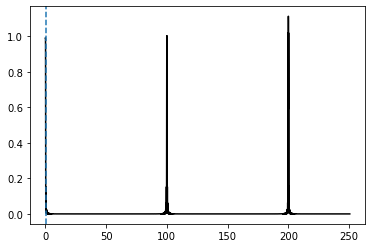

In [5]:
ls2 = LombScargle(x, y2)
freq_2, power_2 = ls2.autopower()
plt.plot(freq_2, power_2, '-k', rasterized=True)
plt.axvline(freq, ls='--')

fmax = freq_sin[np.nanargmax(power_2)]
print(f"Strongest frequency: {fmax:.2f}")

In [6]:
from astropy.convolution import convolve, Box1DKernel
y_smooth = convolve(y2, Box1DKernel(100))
y_hpf = y2 - y_smooth

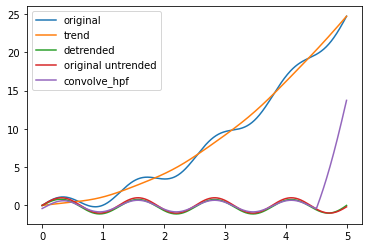

In [7]:
# detrend with a low-pass

order = 100
trend = sps.filtfilt([1] * order, [order], y2)  # this is a very simple moving average filter
plt.plot(x, y2, label='original')
plt.plot(x, trend, label='trend')
plt.plot(x, y2-trend, label='detrended' )
plt.plot(x, y_sin, label='original untrended')
plt.plot(x, y_hpf, label='convolve_hpf')
plt.legend()


In [8]:
sps.filtfilt?

In [9]:
sps.detrend?

In [10]:
from scipy.signal import butter, filtfilt

In [11]:
import pymc3 as pm

from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize
from theano import shared

ModuleNotFoundError: No module named 'pymc3'

In [16]:
from numpy.polynomial.polynomial import polyfit, polyval

In [37]:
deg3fit = polyfit(x, y2, 4)
# y2_minus_deg3fit = y2-deg3fit
y_deg3fit = polyval(x, deg3fit)
# deg3fit
y_deg3fit
y2_minus_deg3fit = y2-y_deg3fit


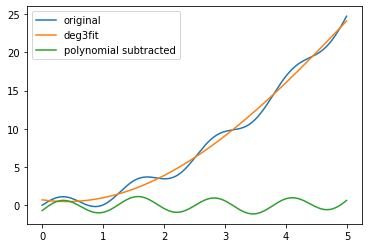

In [38]:
plt.plot(x, y2, label='original')

plt.plot(x, y_deg3fit, label='deg3fit')
plt.plot(x, y2_minus_deg3fit, label='polynomial subtracted')
plt.legend()


# Notes

After futzing around a lot, I think a Gaussian process filter is overkill and I'm going to not do that. Polynomial fitting is it. 4th order should do it?

In [44]:
from wuvars.data.photometry import load_wserv_v2, group_wserv_v2
from wuvars.plotting.lightcurve import ic348_simple_lc_scatter_brokenaxes

ic_dat = group_wserv_v2(load_wserv_v2(8))

# let's grab one Yf guy (esp. if possible this will help)

Loading WSERV8 photometry data... DONE (elapsed time: 0.34s)


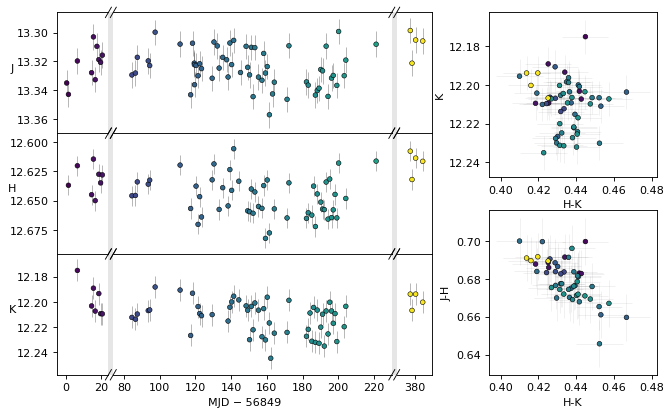

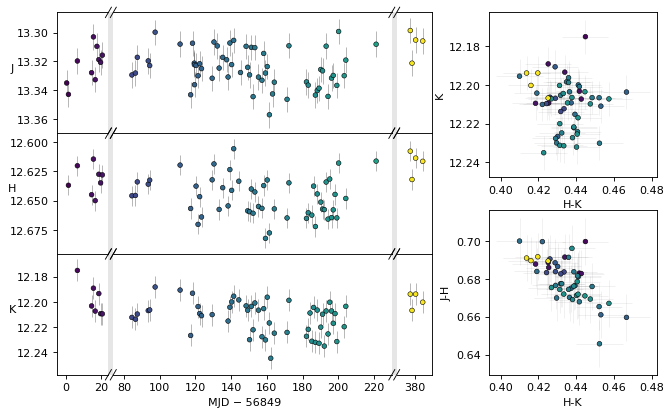

In [49]:
sid = 44989782468907
ic348_simple_lc_scatter_brokenaxes(ic_dat, sid)

In [102]:
from numpy.polynomial.polynomial import polyfit, polyval
import pdb

# let's architect out some ideas

# assume we've been given:
# one star's data in exactly the format we want

def polyfit_data_raw(x, y):
    """ Possibly overkill; we may just use polyfit/polyval directly? """
    pass


# I would like to:
# take in a given SOURCEID's data
# clip it temporally (start/stop provided)
# make this a "copy"
# for each band:
#     do a low order polyfit
#     generate BOTH the fit, and the detrended (fit-subtracted) data
#     plot each. (plus the original data.)

ic_date_offset = 56849
ic_start = 60
ic_end = 250
dat_sid = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid]

def poly_detrend(dat, date_offset=0, data_start=0, data_end=np.inf, poly_order=1, **kwargs):
    
    # dat has already been through a step like this:
    # dat = dg.groups[dg.groups.keys["SOURCEID"] == sid]
    # dg: astropy table that has been grouped by SOURCEID

    unpruned_date = dat["MEANMJDOBS"] - date_offset
    
    season_selection = (unpruned_date >= data_start) & (unpruned_date <= data_end)
    
    dat_pruned = dat[season_selection]
    dp = dat_pruned
    
    detrended_dat = dp.copy()
    fit_dat = dp.copy()
    
    #generate the polyfit
    bands = ['J', 'H', 'K']
    
    date = dp["MEANMJDOBS"] - date_offset
    mjd = dp["MEANMJDOBS"]
    
    for band in bands:

        mask = dp[f"{band}APERMAG3"].mask
        times = dp["MEANMJDOBS"][~mask] - date_offset

        mags_raw = dp[f"{band}APERMAG3"]
        errs_raw = dp[f"{band}APERMAG3ERR"]

        mags = dp[f"{band}APERMAG3"][~mask]
        errs = dp[f"{band}APERMAG3ERR"][~mask]
                        
        fit_params = polyfit(times, mags, poly_order, w=1/errs)
        fit_mag = polyval(date, fit_params)
        
        mag_mean = np.mean(mags)
        detrended_mags = mags_raw - fit_mag + mag_mean
        
        plt.figure(figsize=(16,4))
        plt.subplot(121)
        plt.plot(date, fit_mag)
        plt.errorbar(times, mags, yerr=errs, fmt='k.')
        plt.gca().invert_yaxis()
        
        plt.subplot(122)
        plt.errorbar(date, detrended_mags, yerr=errs_raw, fmt='k.')
        plt.gca().invert_yaxis()
        
        # overwrite
        
        detrended_dat[f"{band}APERMAG3"] = detrended_mags
        fit_dat[f"{band}APERMAG3"] = fit_mag
        
    return detrended_dat, fit_dat
        

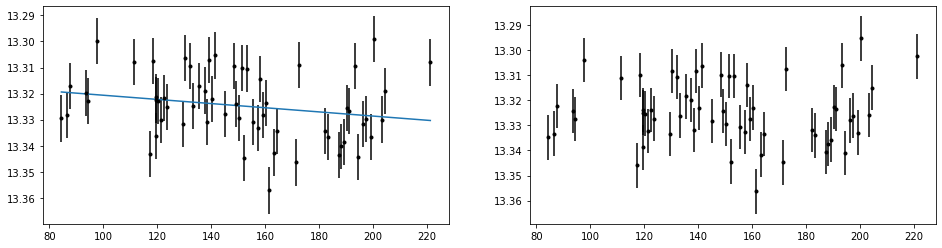

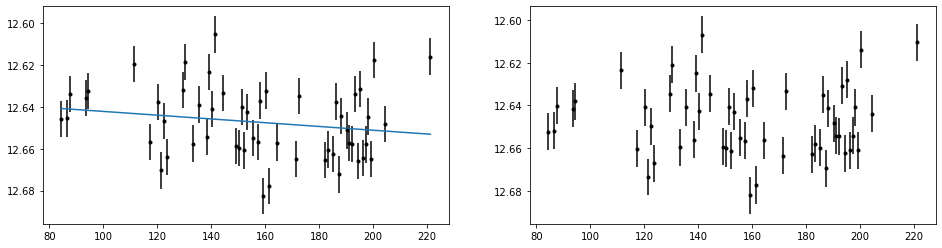

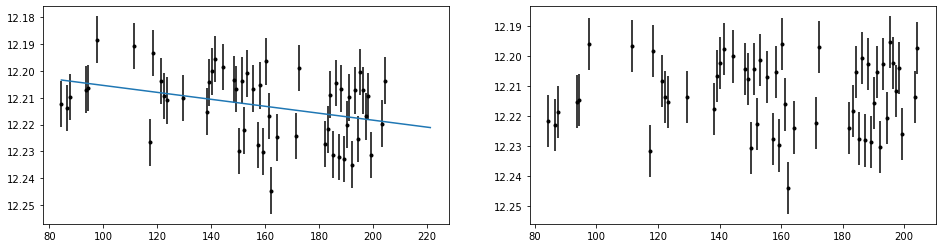

In [104]:
detrended, fit = poly_detrend(dat_sid, ic_date_offset, ic_start, ic_end, poly_order=1)

In [57]:
polyfit?

In [58]:
polyval?

In [105]:
from wuvars.analysis.detrending import poly_detrend

In [111]:
star_dat = detrended

2.335347579012922
2.338624493295915
2.334802319246634


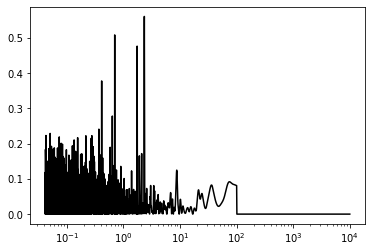

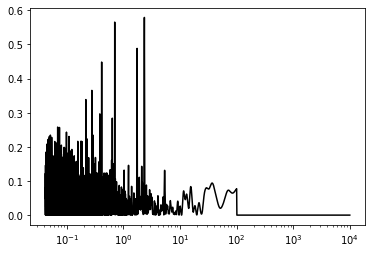

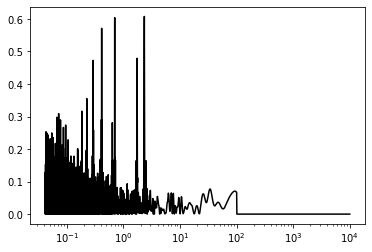

In [113]:
from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, N_eval)

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]


    ls = LombScargle(times, mags, dy=errs)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    
    print(1/fmax)

In [114]:
period = np.mean([2.335347579012922, 2.338624493295915, 2.334802319246634])

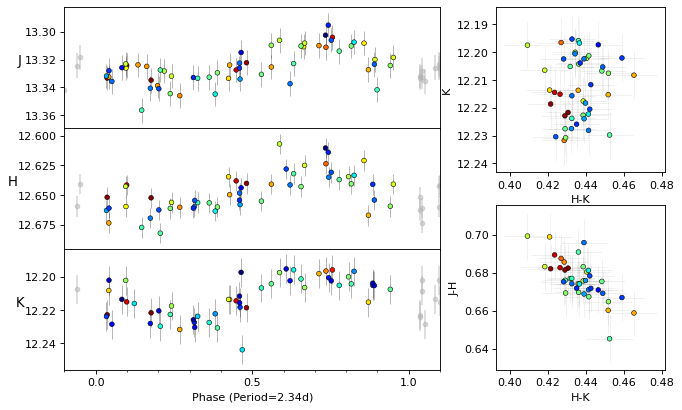

In [126]:
from wuvars.plotting.lightcurve import simple_phased_lc_scatter_gridspec, simple_lc_scatter, simple_lc_scatter_brokenaxes

fig = simple_phased_lc_scatter_gridspec(
    detrended.group_by('SOURCEID'), sid, period, cmap='jet_r'
)


[(-5.0, 143.0)]


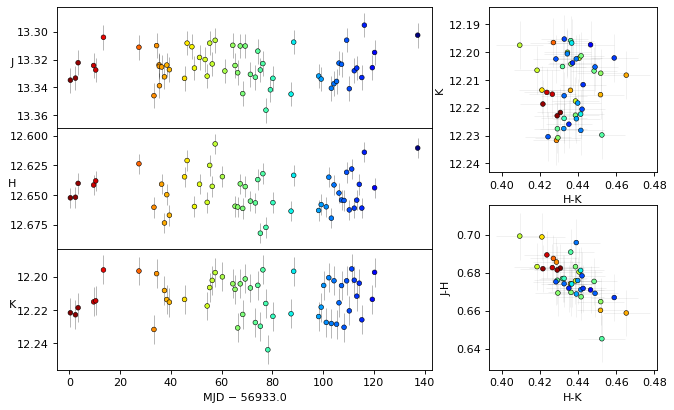

In [133]:
# the above is a proof of concept of detrending.
fig = simple_lc_scatter_brokenaxes(
    detrended.group_by('SOURCEID'), sid, cmap='jet_r', breaks=[]
)


[(-5.0, 143.0)]


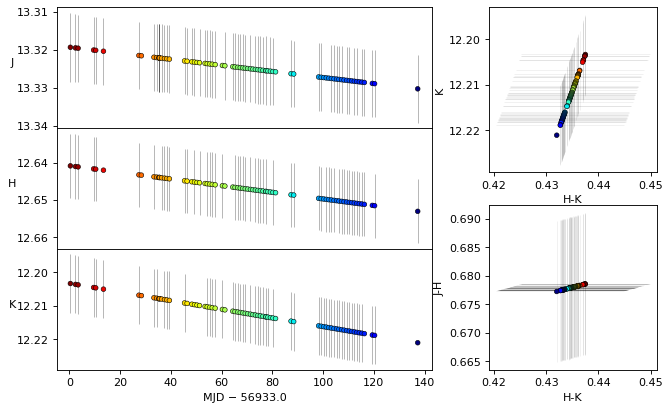

In [134]:
# the above is a proof of concept of detrending.
fig = simple_lc_scatter_brokenaxes(
    fit.group_by('SOURCEID'), sid, cmap='jet_r', breaks=[]
)


In [138]:
# now let's try multiterm fits...

new_sid = 44989782469408
new_dat_sid = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == new_sid]


2.242059043348281
2.2470973782771537
2.2470973782771537


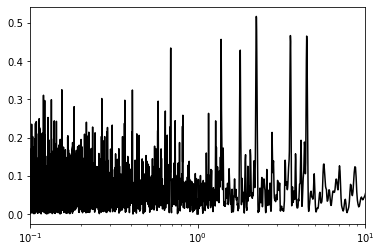

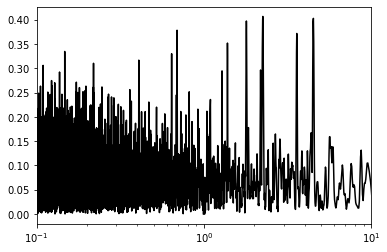

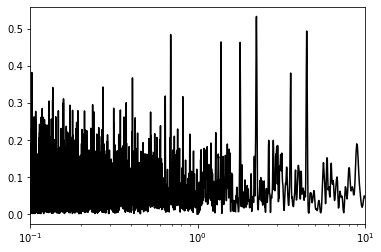

In [153]:
from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, int(N_eval/10))

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

star_dat = new_dat_sid

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]
    
    valid = (times >= (ic_date_offset + ic_start)) & (times <= (ic_date_offset + ic_end))


    ls = LombScargle(times[valid], mags[valid], dy=errs[valid], nterms=2)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
#     fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    plt.xlim(0.1, 10)
    
    print(1/fmax)

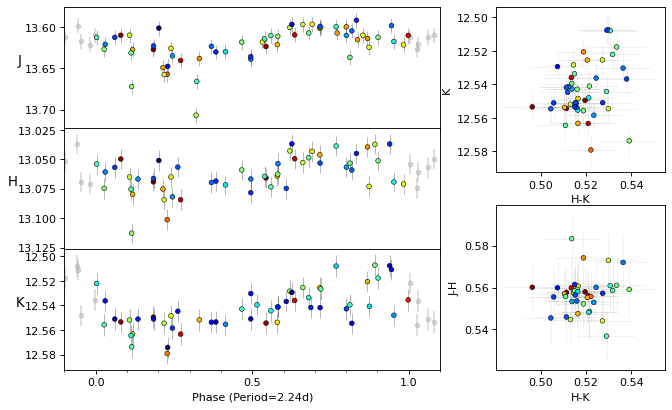

In [156]:
pruned = ic_dat[(ic_dat['MEANMJDOBS'] >= ic_date_offset + ic_start) & (ic_dat['MEANMJDOBS'] <= ic_date_offset + ic_end)]

fig = simple_phased_lc_scatter_gridspec(
    pruned.group_by('SOURCEID'), new_sid, 4.484118086696562/2, cmap='jet_r'
)

In [136]:
ls.power?

In [142]:
2.24 / 3.59

0.6239554317548748

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]


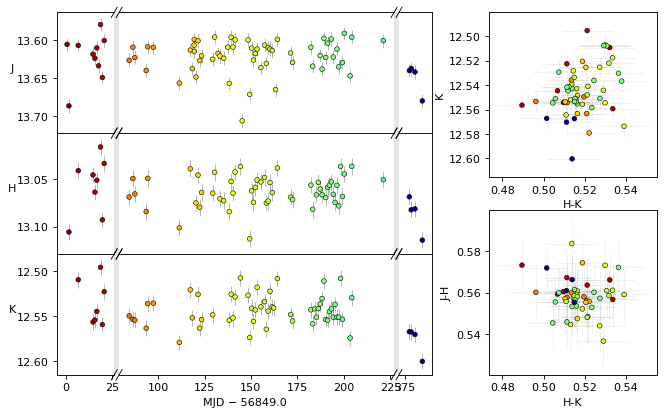

In [145]:
fig = simple_lc_scatter_brokenaxes(
    ic_dat, new_sid, cmap='jet_r'
)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]


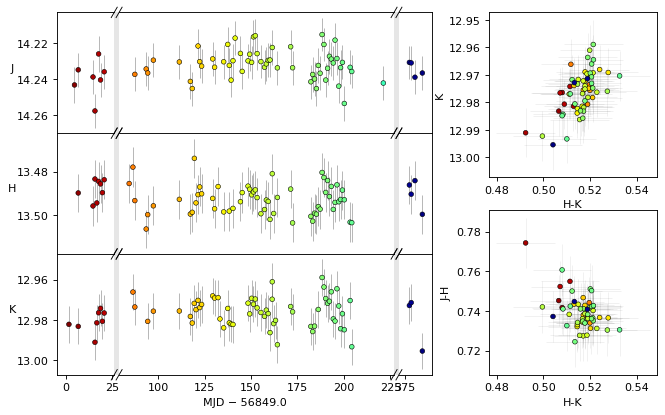

In [158]:
sid_70 = 44989782443120
fig = simple_lc_scatter_brokenaxes(
    ic_dat, sid_70, cmap='jet_r'
)
dat_70 = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid_70]


In [159]:
detrended_70, fit_70 = poly_detrend(dat_70, ic_date_offset, ic_start, ic_end, poly_order=1)

[(-5.0, 143.0)]


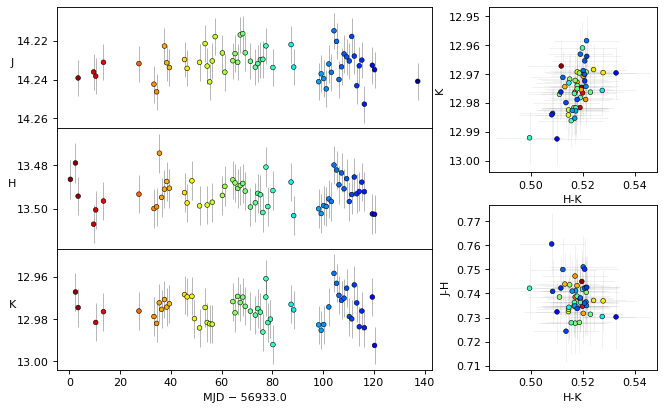

In [160]:
fig = simple_lc_scatter_brokenaxes(
    detrended_70.group_by('SOURCEID'), sid_70, cmap='jet_r', breaks=[]
)


0.3276204283108912
0.48777905142838557
0.4877076830537131


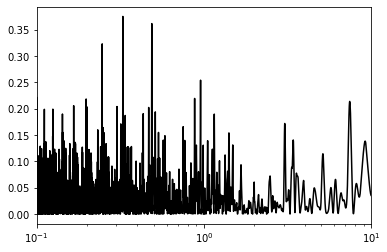

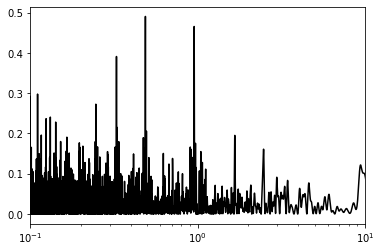

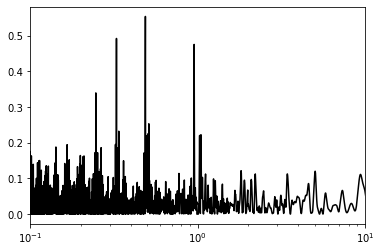

In [162]:
star_dat = detrended_70

from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, N_eval)

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]


    ls = LombScargle(times, mags, dy=errs)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    plt.xlim(0.1, 10)
    
    print(1/fmax)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]


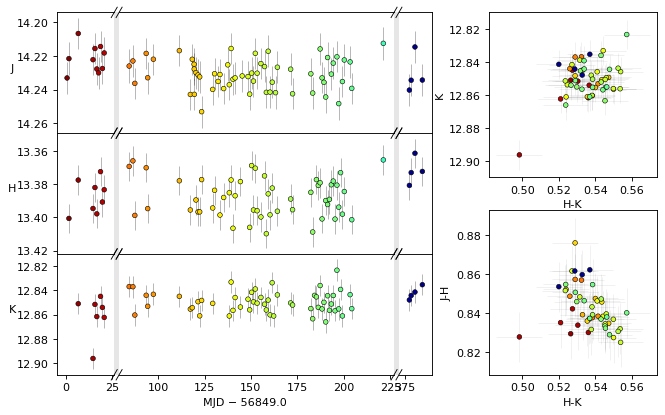

In [163]:
sid_71 = 44989782467954
fig = simple_lc_scatter_brokenaxes(
    ic_dat, sid_71, cmap='jet_r'
)

In [164]:
dat_71 = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid_71]
detrended_71, fit_71 = poly_detrend(dat_71, ic_date_offset, ic_start, ic_end, poly_order=1)

[(-5.0, 143.0)]


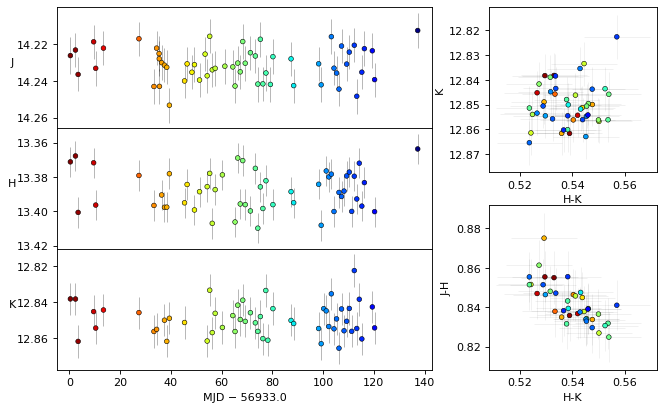

In [165]:
fig = simple_lc_scatter_brokenaxes(
    detrended_71.group_by('SOURCEID'), sid_71, cmap='jet_r', breaks=[]
)


1.7714718039563035
2.280492208285823
2.2810123935523112


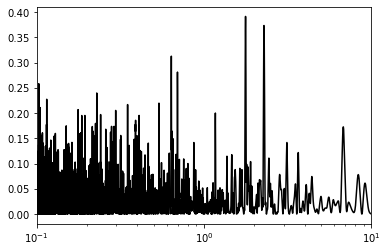

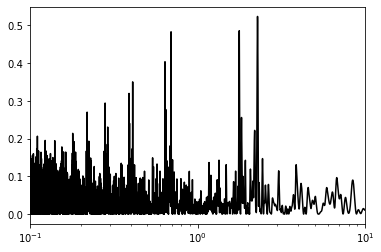

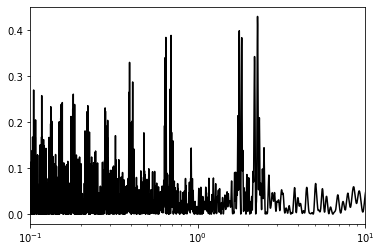

In [166]:
star_dat = detrended_71

from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, N_eval)

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]


    ls = LombScargle(times, mags, dy=errs)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    plt.xlim(0.1, 10)
    
    print(1/fmax)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]


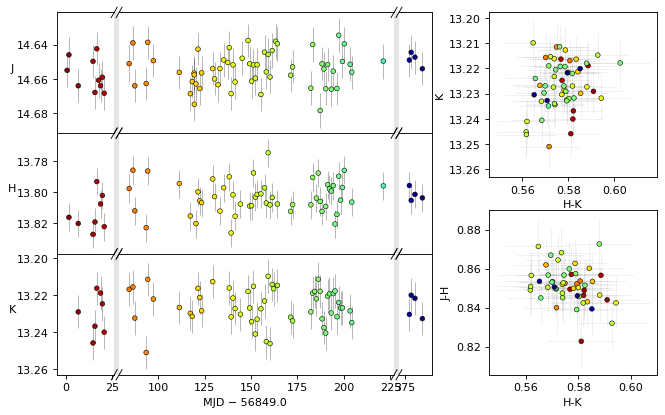

In [167]:
sid_83 = 44989782467561
fig = simple_lc_scatter_brokenaxes(
    ic_dat, sid_83, cmap='jet_r'
)

In [168]:
dat_83 = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid_83]
detrended_83, fit_83 = poly_detrend(dat_83, ic_date_offset, ic_start, ic_end, poly_order=1)

0.7283290847293032
2.6968603919453433
2.6968603919453433


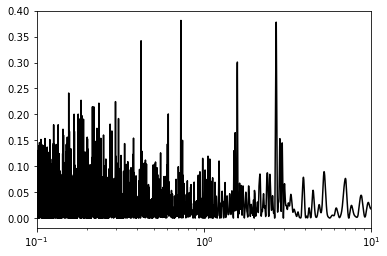

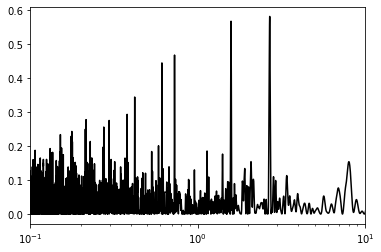

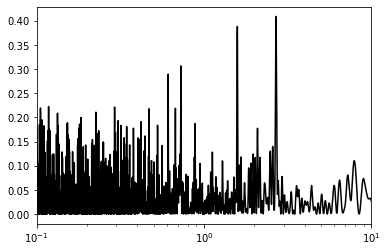

In [169]:
star_dat = detrended_83

from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, N_eval)

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]


    ls = LombScargle(times, mags, dy=errs)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    plt.xlim(0.1, 10)
    
    print(1/fmax)

[(-5.0, 143.0)]


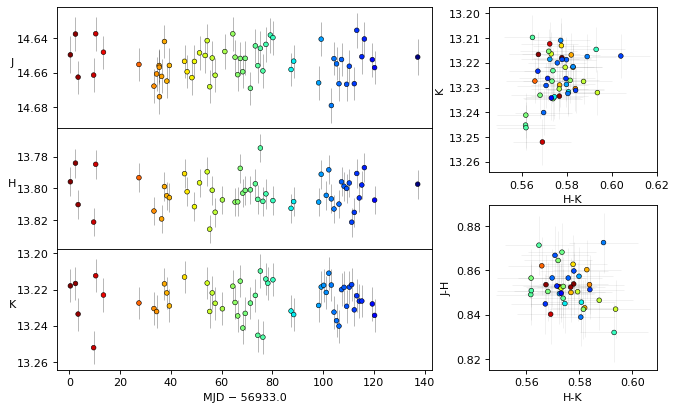

In [170]:
fig = simple_lc_scatter_brokenaxes(
    detrended_83.group_by('SOURCEID'), sid_83, cmap='jet_r', breaks=[]
)


[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]


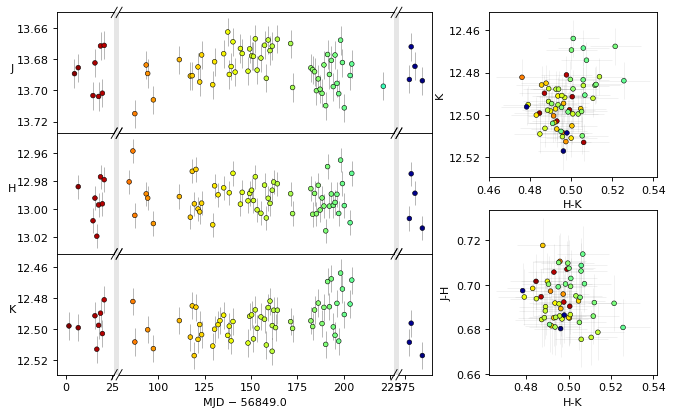

In [171]:
sid_91 = 44989782442939
fig = simple_lc_scatter_brokenaxes(
    ic_dat, sid_91, cmap='jet_r'
)

In [179]:
dat_91 = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid_91]
detrended_91, fit_91 = poly_detrend(dat_91, ic_date_offset, ic_start, ic_end, poly_order=2)

[(-5.0, 143.0)]


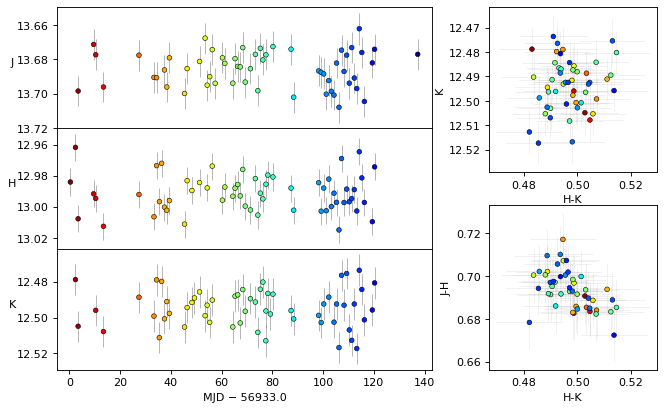

In [180]:
fig = simple_lc_scatter_brokenaxes(
    detrended_91.group_by('SOURCEID'), sid_91, cmap='jet_r', breaks=[]
)


[(-5.0, 143.0)]


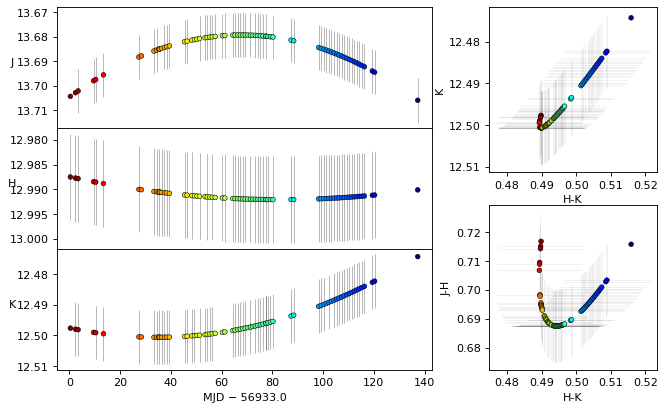

In [181]:
fig = simple_lc_scatter_brokenaxes(
    fit_91.group_by('SOURCEID'), sid_91, cmap='jet_r', breaks=[]
)


2.438419491181013
0.4141283941414392
2.438419491181013


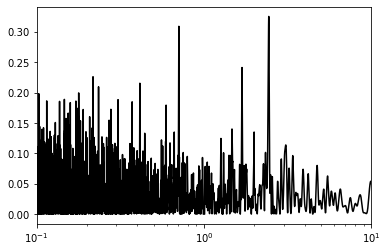

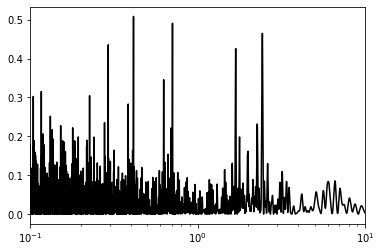

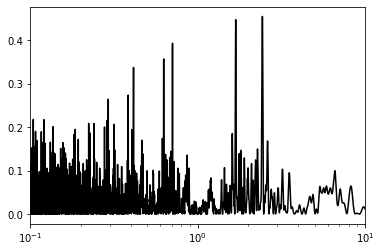

In [182]:
star_dat = detrended_91

from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, N_eval)

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]


    ls = LombScargle(times, mags, dy=errs)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    plt.xlim(0.1, 10)
    
    print(1/fmax)

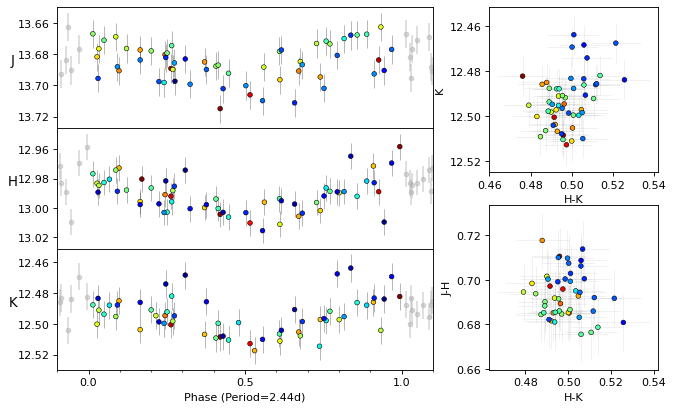

In [183]:
pruned = ic_dat[(ic_dat['MEANMJDOBS'] >= ic_date_offset + ic_start) & (ic_dat['MEANMJDOBS'] <= ic_date_offset + ic_end)]

fig = simple_phased_lc_scatter_gridspec(
    pruned.group_by('SOURCEID'), sid_91, 2.438419491181013, cmap='jet_r'
)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]


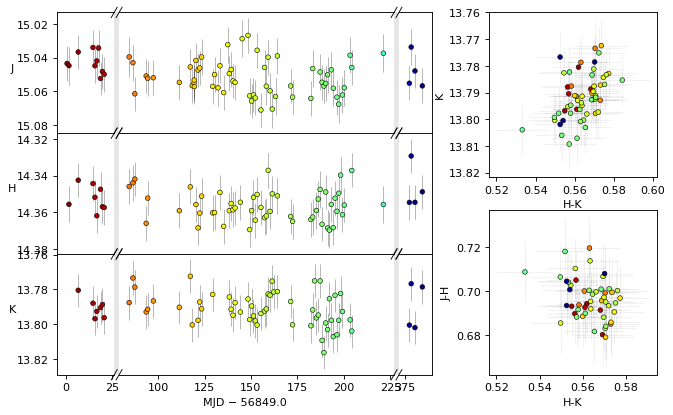

In [184]:
sid_96 = 44989782467337
fig = simple_lc_scatter_brokenaxes(
    ic_dat, sid_96, cmap='jet_r'
)

In [190]:
dat_96 = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid_96]
detrended_96, fit_96 = poly_detrend(dat_96, ic_date_offset, ic_start, ic_end, poly_order=2)

[(-5.0, 143.0)]
[(-5.0, 143.0)]


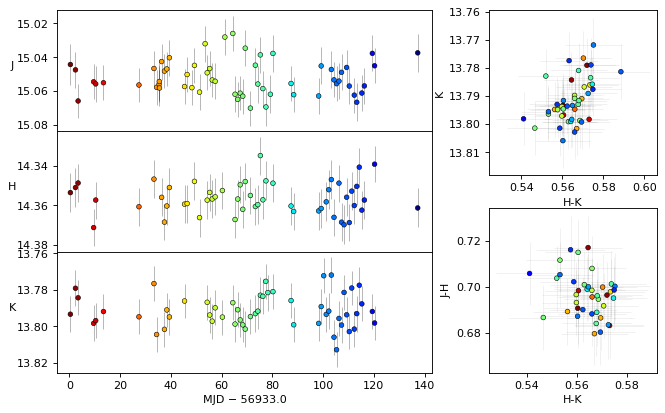

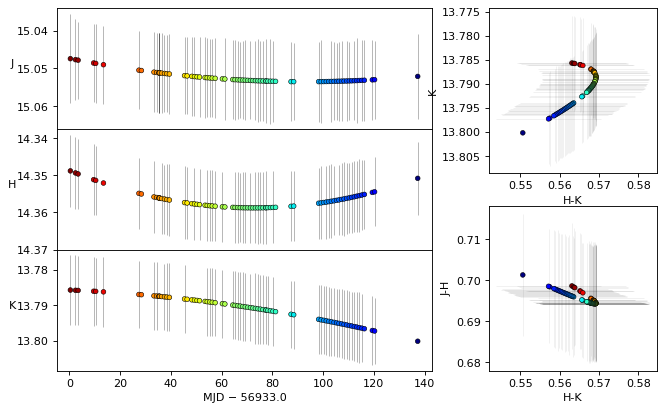

In [191]:
fig = simple_lc_scatter_brokenaxes(
    detrended_96.group_by('SOURCEID'), sid_96, cmap='jet_r', breaks=[]
)
fig = simple_lc_scatter_brokenaxes(
    fit_96.group_by('SOURCEID'), sid_96, cmap='jet_r', breaks=[]
)


1.5556873573947314
2.785503714020427
0.05647651884817542


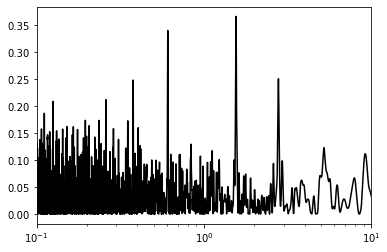

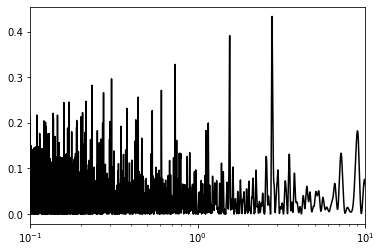

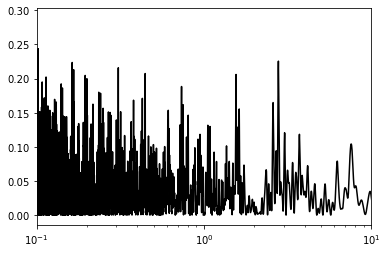

In [192]:
star_dat = detrended_96

from astropy.timeseries import LombScargle
from wuvars.analysis.periods import f_max, f_min, N_eval
freq = np.linspace(f_min, f_max, N_eval)

# detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

for band in ['J', 'H', 'K']:
# band = 'K'
    mask = star_dat[f"{band}APERMAG3"].mask
    times = star_dat["MEANMJDOBS"][~mask]
    mags = star_dat[f"{band}APERMAG3"][~mask]
    errs = star_dat[f"{band}APERMAG3ERR"][~mask]


    ls = LombScargle(times, mags, dy=errs)
    power = ls.power(freq, assume_regular_frequency=True).value

    min_freq = 1 / 100
    power[freq < min_freq] = 0
    power[np.abs(freq-1) < 0.01] = 0

    powermax = np.nanmax(power)
    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power)).value

    amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))
    
    plt.figure()
    plt.plot(1/freq, power, 'k', rasterized=True)
    plt.semilogx()
    plt.xlim(0.1, 10)
    
    print(1/fmax)

In [208]:
def treatment(sid, poly_order=1, nterms=1):
    fig = simple_lc_scatter_brokenaxes(
        ic_dat, sid, cmap='jet_r'
    )
    
    dat_sid = ic_dat.groups[ic_dat.groups.keys["SOURCEID"] == sid]
    detrended, fit = poly_detrend(dat_sid, ic_date_offset, ic_start, ic_end, poly_order=poly_order)
    
    fig = simple_lc_scatter_brokenaxes(
        detrended.group_by('SOURCEID'), sid, cmap='jet_r', breaks=[]
    )
    fig = simple_lc_scatter_brokenaxes(
        fit.group_by('SOURCEID'), sid, cmap='jet_r', breaks=[]
    )
    
    
    star_dat = detrended

    from astropy.timeseries import LombScargle
    from wuvars.analysis.periods import f_max, f_min, N_eval
    freq = np.linspace(f_min, f_max, N_eval)

    # detrended_dat, fit_dat = poly_detrend(star_dat, ic_date_offset, ic_start, ic_end, poly_order=1)

    for band in ['J', 'H', 'K']:
    # band = 'K'
        mask = star_dat[f"{band}APERMAG3"].mask
        times = star_dat["MEANMJDOBS"][~mask]
        mags = star_dat[f"{band}APERMAG3"][~mask]
        errs = star_dat[f"{band}APERMAG3ERR"][~mask]


        ls = LombScargle(times, mags, dy=errs, nterms=nterms)
        power = ls.power(freq, assume_regular_frequency=True).value

        min_freq = 1 / 100
        power[freq < min_freq] = 0
        power[np.abs(freq-1) < 0.01] = 0

        powermax = np.nanmax(power)
        fmax = freq[np.nanargmax(power)]
#         fap = ls.false_alarm_probability(np.nanmax(power)).value

        amp = np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2))

        plt.figure()
        plt.plot(1/freq, power, 'k', rasterized=True)
        plt.semilogx()
        plt.xlim(0.1, 10)

        print(1/fmax)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]
[(-5.0, 143.0)]
[(-5.0, 143.0)]
0.40102495722382636
2.034993555826889
1.9550260671228414


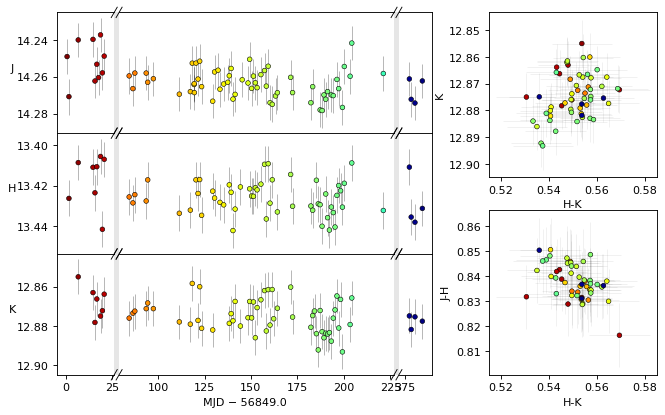

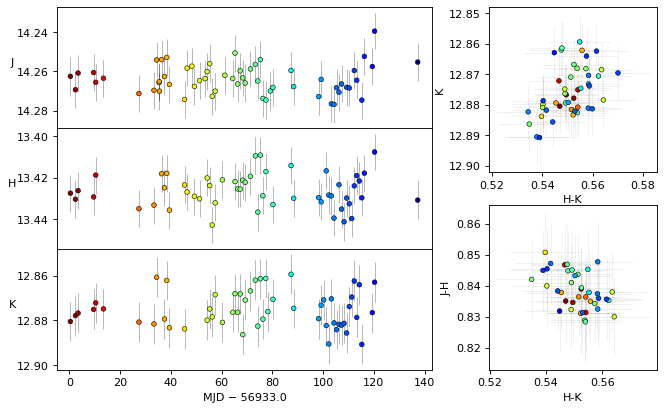

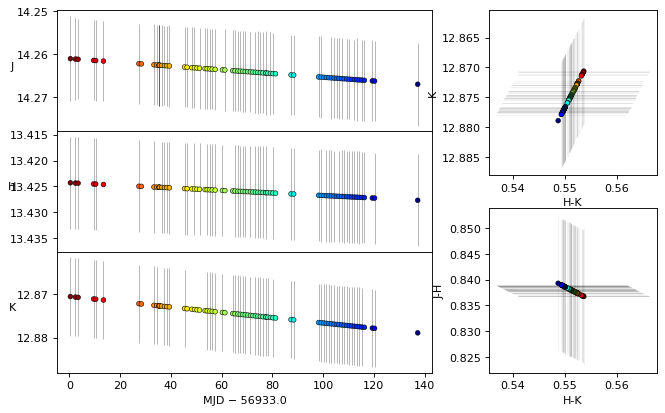

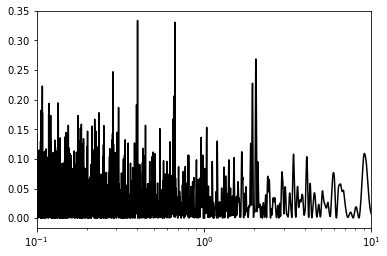

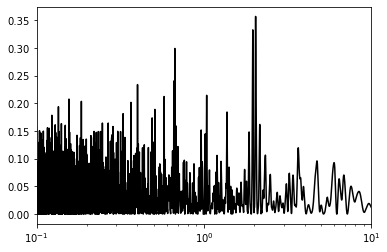

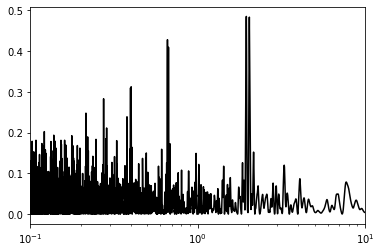

In [196]:
sid_98 = 44989782467264
treatment(sid_98)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]
[(-5.0, 143.0)]
[(-5.0, 143.0)]
2.603477826954786
2.6007693974859123
1.622053257637199


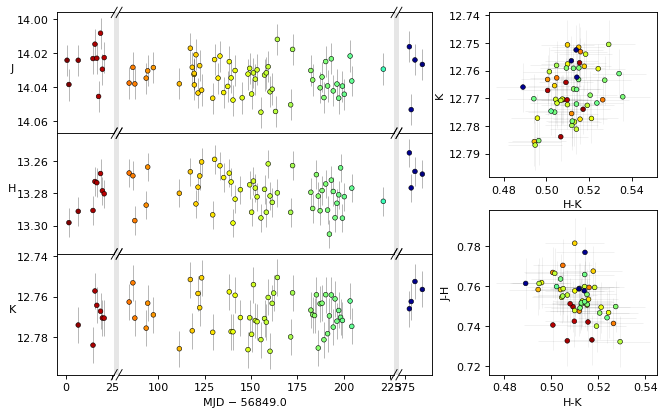

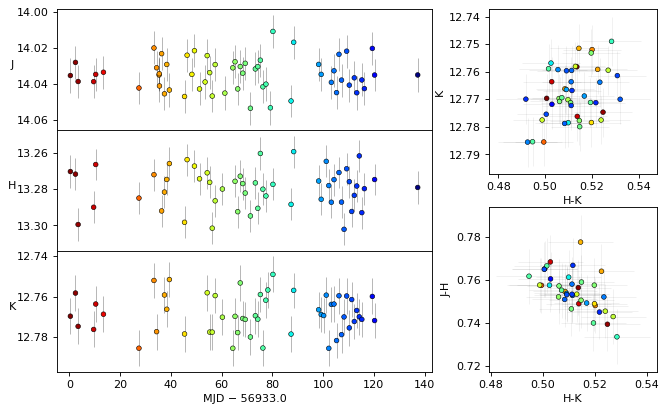

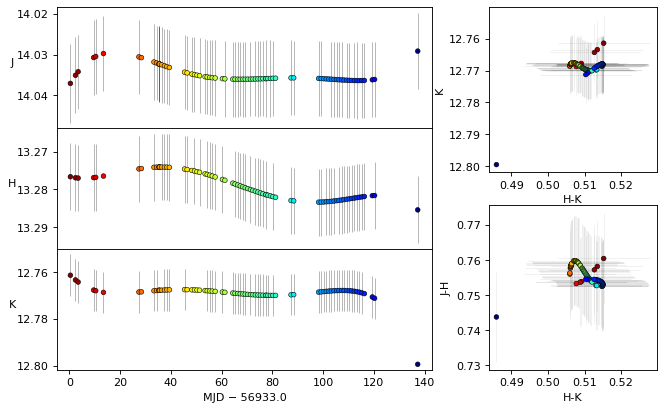

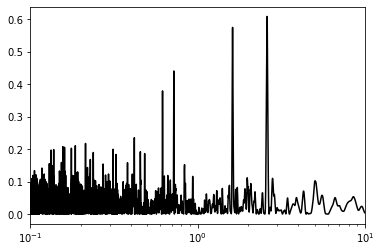

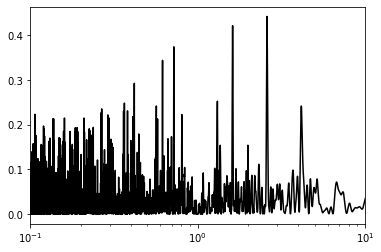

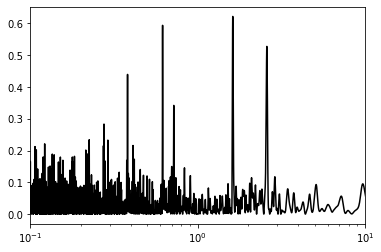

In [202]:
sid_105 = 44989782467281
treatment(sid_105, poly_order=5)

[(-5.0, 26.0), (79.0, 227.0), (372.0, 390.0)]
[(-5.0, 143.0)]
[(-5.0, 143.0)]
3.1026864205191846
6.180443963741244
1.474485156787575


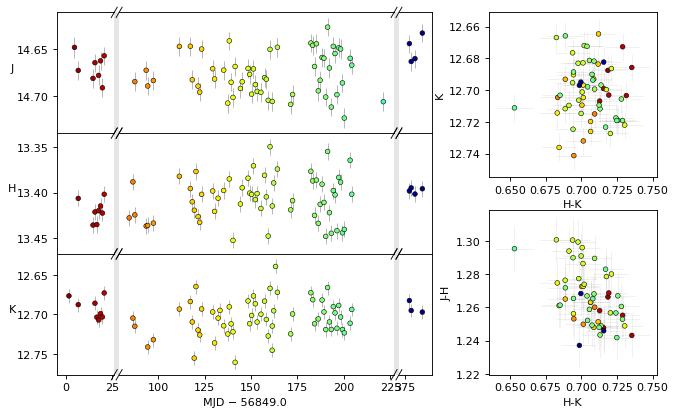

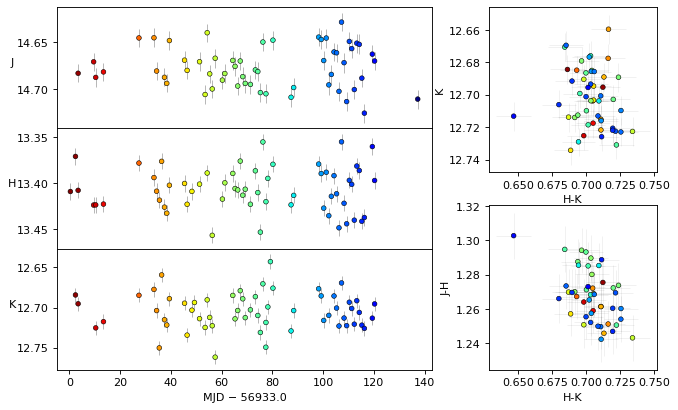

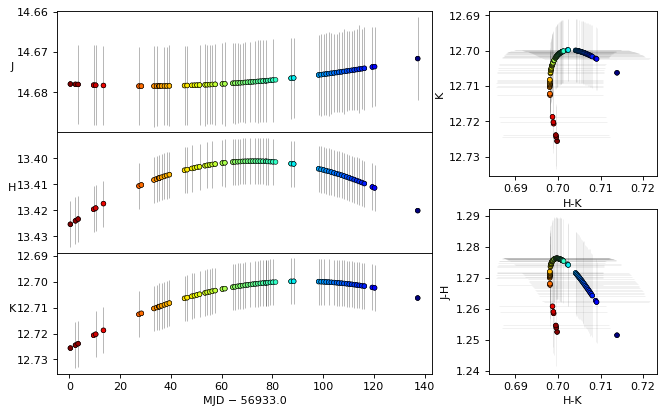

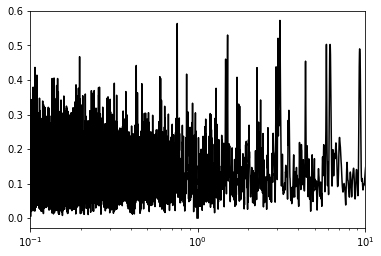

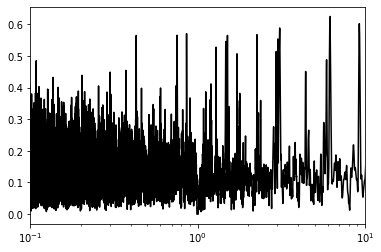

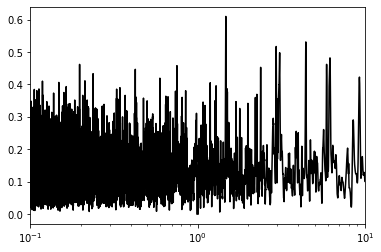

In [210]:
sid_111 = 44989782440424
treatment(sid_111, poly_order=2, nterms=4)